# Lesson 04: Word Representations (Sparse)

In this lesson, we explore sparse word representations using the ANPC press releases dataset.
We will cover:
1. **Bag of Words (BoW)**
2. **TF-IDF**
3. **BM25**

We apply these representations to advanced tasks:
- **Authorship Identification**: Stylistic clustering using stopwords.
- **Seasonal Analysis**: Identifying trends in issues across seasons.

And provide exercises for:
- **Search Engine** (BM25)
- **Article Similarity** (TF-IDF)
- **Keyword Extraction** (TF-IDF)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add the module to path for imports to work
sys.path.append(os.path.abspath('..'))

from representations.bow import BoWRepresentation
from representations.tfidf import TFIDFRepresentation
from representations.bm25 import BM25Representation
from tasks.authorship import AuthorshipIdentifier
from tasks.seasonal_analysis import SeasonalAnalyzer

## 1. Load Preprocessed Data

We use the preprocessed ANPC data from Lesson 02.

In [2]:
data_path = "../../02_data_preprocessing/data/processed/articles_anpc_preprocessed.json"
df = pd.read_json(data_path)
print(f"Loaded {len(df)} articles.")

Loaded 237 articles.


## 2. Importance of Stopwords

In the previous iteration, generic words like "ANPC", "comisar", or "lei" dominated our representations. 
We now use a refined stopword list to gain more meaningful insights.

In [3]:
from utils import get_improved_stopwords
print(f"Number of refined stopwords: {len(get_improved_stopwords())}")
print(f"Sample: {get_improved_stopwords()[:10]}")

Number of refined stopwords: 48
Sample: ['avut', 'sunt', 'pe', 'lipsă', 'cu', 'al', 'prin', 'a', 'urmare', 'lei']


## 3. Bag of Words (BoW)

Let's see how BoW looks with improved stopwords.

/home/marius/ore/inlp/gh/inlp/04_word_representations/representations/bow.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df, palette='viridis')


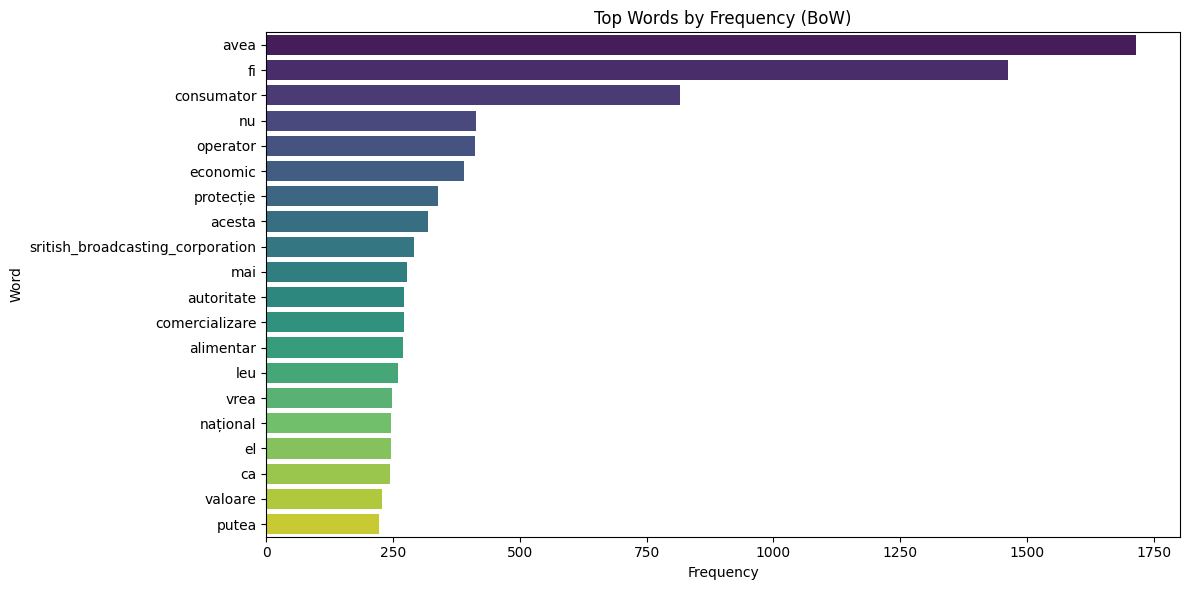

In [4]:
documents = df['lemmatized_content'].tolist()
bow = BoWRepresentation(max_features=1000)
bow.fit_transform(documents)
bow.plot_top_words(n=20)

## 4. TF-IDF

TF-IDF scores should now highlight more specific issues rather than generic terminology.

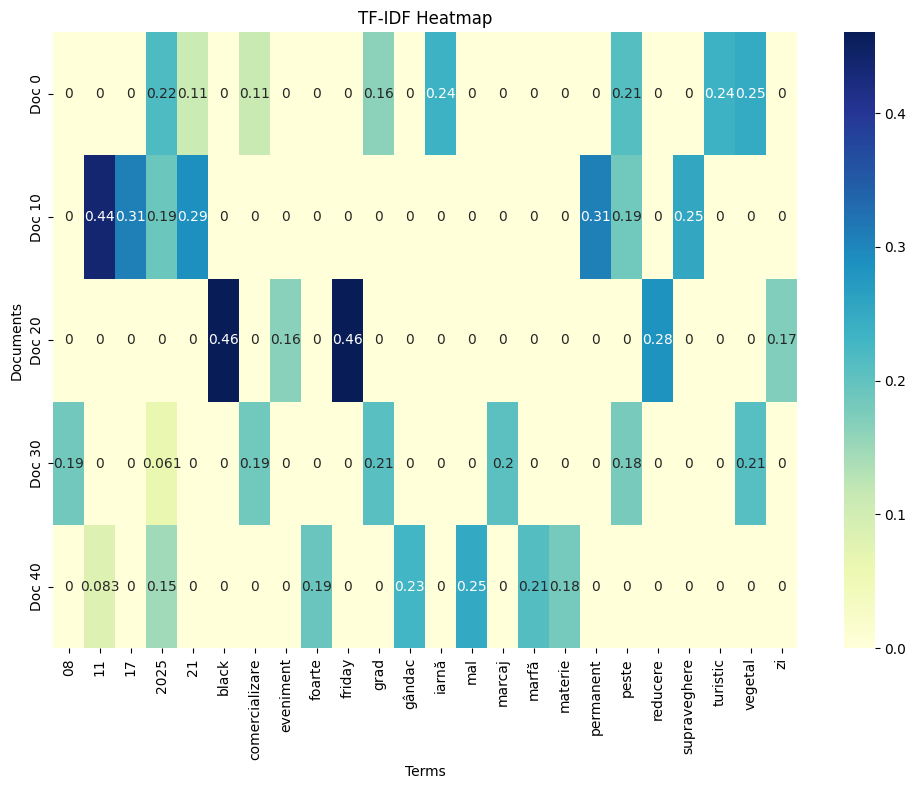

In [5]:
tfidf = TFIDFRepresentation(max_features=1000)
tfidf.fit_transform(documents)
tfidf.plot_tfidf_heatmap(doc_indices=[0, 10, 20, 30, 40], n_words=5)

## 5. Task: Authorship Identification (Stylistic Clustering)

Can we identify different "writing styles" in the press releases? 
Instead of looking at the *content* (what they talk about), we look at the *style* (how they use functional words).

**Technical Approach**:
- We use ONLY **stopwords** (functional words like "și", "dar", "pe", "cu") as features.
- Content-bearing words are excluded to focus on stylistic fingerprints.
- KMeans clustering identifies groups of articles with similar functional word distributions.

**Insight**: Differences in stopword frequencies often reveal different human authors or different departmental templates used for writing the press releases.

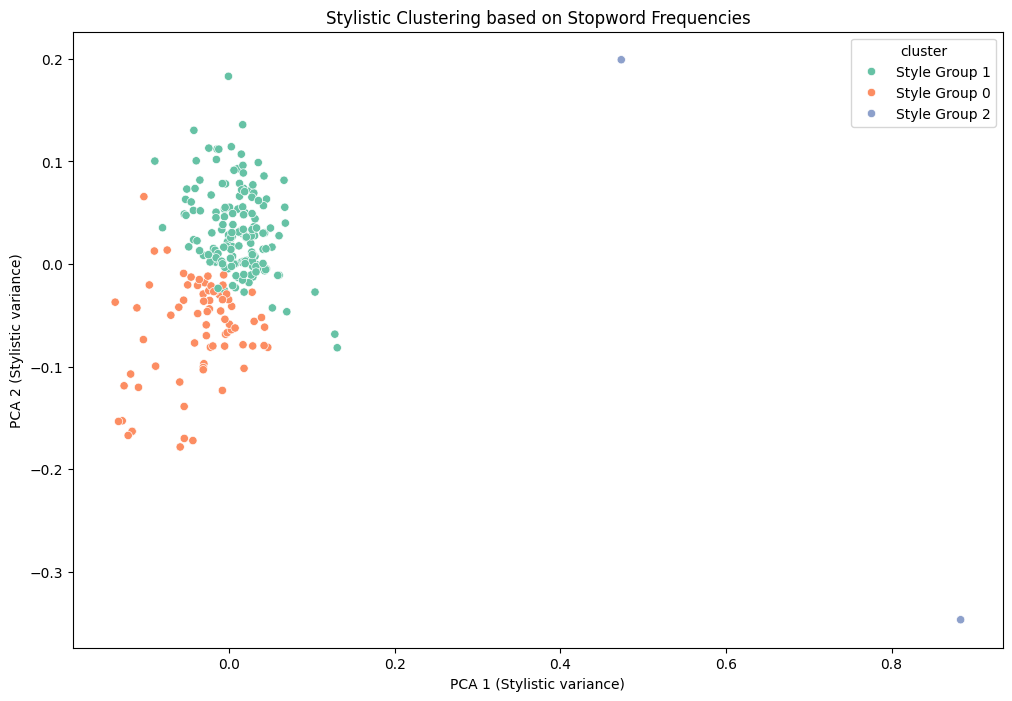

In [6]:
author_id = AuthorshipIdentifier(n_clusters=3)
author_id.cluster_articles(documents)
author_id.plot_author_clusters(documents)

### Stylistic Markers
Let's see which functional words define each style group.

In [7]:
markers = author_id.get_stylistic_markers(n_words=10)
for i, words in enumerate(markers):
    print(f"Style Group {i}: {', '.join(words)}")

Style Group 0: în, de, al, și, pentru, la, anpc, un, care, din
Style Group 1: de, în, și, al, la, un, cu, pentru, produs, care
Style Group 2: și, de, o, acest, magazine, în, constatat, neconformitate, toate, aceasta


## 6. Task: Seasonal Issue Analysis

Do certain problems occur more frequently in specific seasons?

**Technical Refinement**:
1. **Bigrams Only**: We use `ngram_range=(2, 2)` to capture meaningful concepts like "black friday" or "gaz natural" instead of isolated words.
2. **Super-Document TF-IDF**: We treat each season as a single large document and calculate TF-IDF across the four seasons.
3. **Uniqueness Filter**: We post-process results to remove bigrams that appear in too many seasons (e.g., in 3 or 4). This filters out generic phrases like "respectare prevedere" or "comisariat județean" that are common year-round.

**Insight**: This reveal issues that are truly **unique** to a season:
- **Autumn**: "black friday", "preț referință" (sales pricing issues).
- **Winter**: "gaz natural", "electric gaz" (energy contracts/billing).
- **Spring**: "agenție turism", "linie credit" (holiday planning and financial products).
- **Summer**: "comandament litoral", "sezon estival" (beach inspections).

In [8]:
seasonal_analyzer = SeasonalAnalyzer(df)
seasonal_keywords = seasonal_analyzer.get_seasonal_keywords(n_words=10)

for season, word_scores in seasonal_keywords.items():
    words = list(word_scores.keys())
    print(f"{season}: {', '.join(words)}")

Winter: sun plaza, ingredient primar, gaz natural, plaza deficient, ro wp, wp content, content uploads, electric gaz, https ro, og 21
Spring: agenție turism, serviciu financiar, wizz air, linie credit, bon comandă, carne proaspăt, zi mai, proaspăt pasăre, grafic rambursare, încă dată
Summer: comandament litoral, apă mineral, transport public, persoană dizabilitate, băutură răcoritor, sezon estival, 000 litru, suc nectar, insolvență persoană, 08 2025
Autumn: black friday, sritish_broadcasting_corporation www, alimentație public, sritish_broadcasting_corporation cluj, ultim 30, preț referință, 10 2025, intermediar credit, special black, preț redus


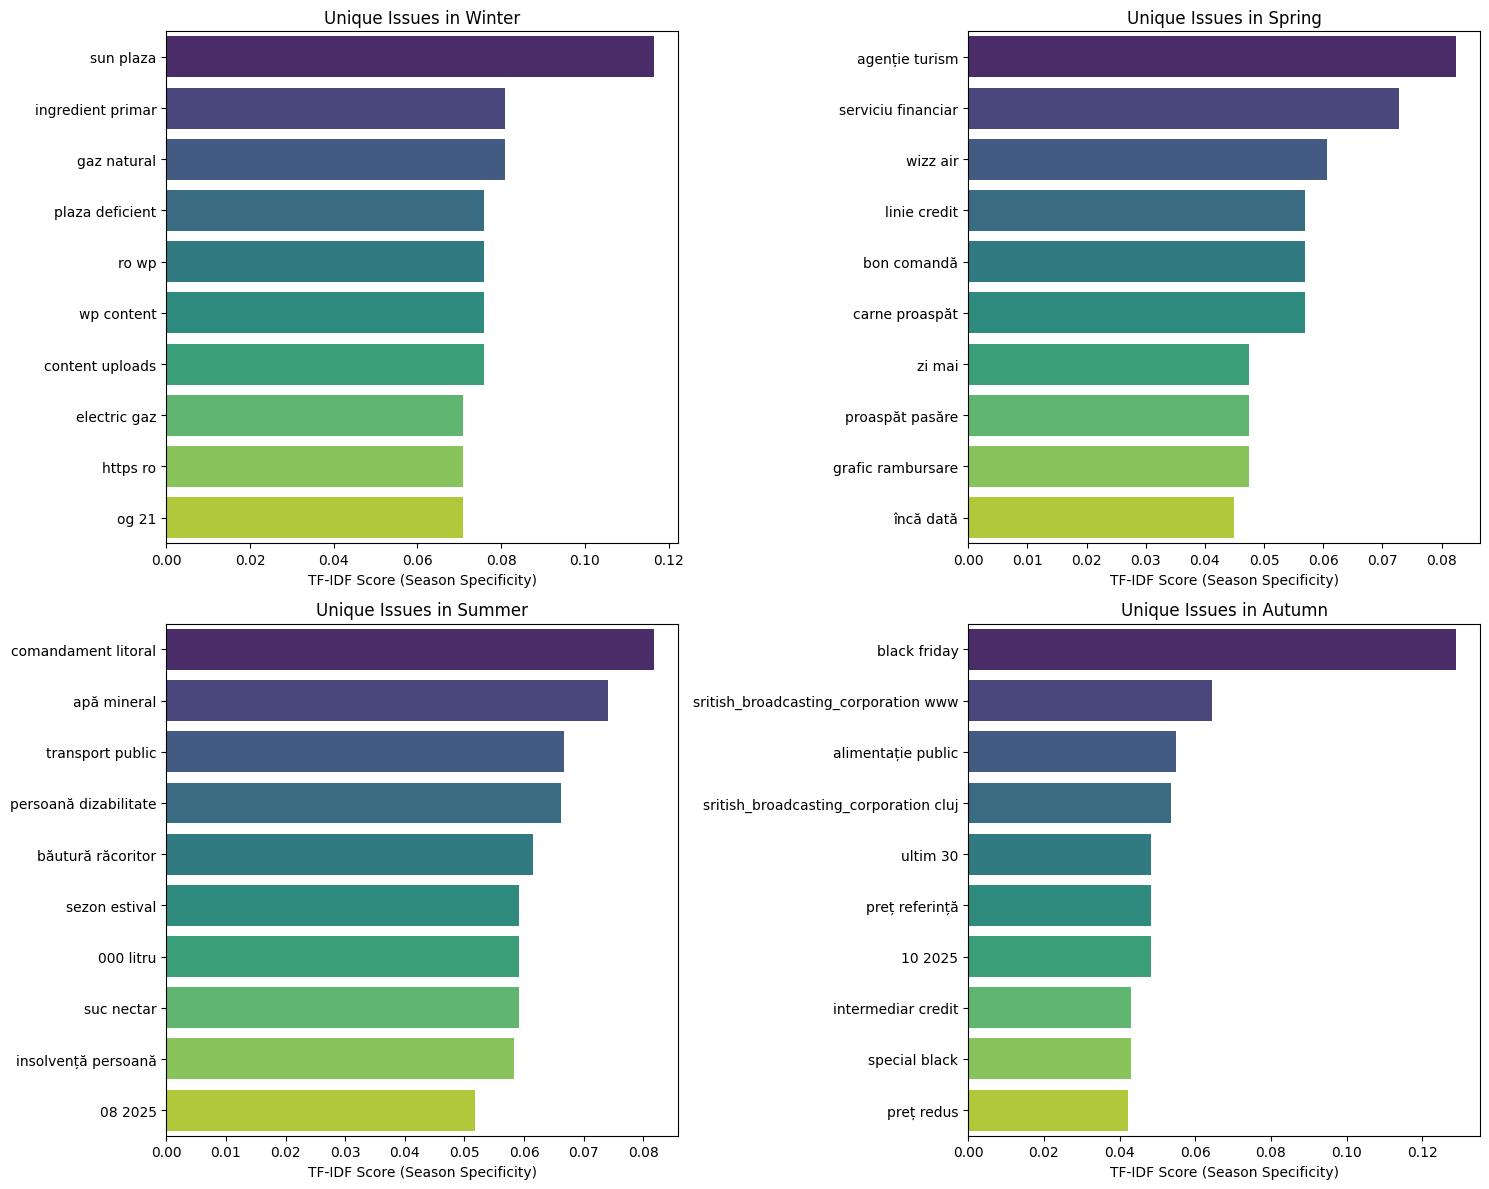

In [9]:
seasonal_analyzer.plot_seasonal_trends(n_words=10)

---
## Exercises

### Exercise 1: Multi-field Weighted Search
Implement a search engine that queries both the `title` and the `lemmatized_content`.

**Challenge**: Assign different weights to the matches (e.g., title matches are 3x more important than content matches).

### Exercise 2: Hybrid Recommender
Improve the article recommender by combining TF-IDF similarity with other factors.

**Challenge**: Incorporate **Authorship Style** (Section 5). Boost the similarity score if two articles belong to the same style group.

### Exercise 3: Temporal Burstiness
"Black Friday" is a seasonal bigram, but when exactly does it "burst"?

**Challenge**: Plot the frequency of "black friday" week-by-week. Can you identify the exact moment the ANPC starts warning consumers about sales?

### Exercise 4: Change Point Detection in Style
Do stylistic shifts happen gradually or suddenly?

**Challenge**: Calculate the average stylistic profile (stopword frequencies) for each month. Use a distance metric (like Euclidean or Cosine) to find the month with the largest stylistic shift from the previous one.

### Exercise 5: Heaps' Law (Vocabulary Growth)
Does our vocabulary keep growing as we add more articles?

**Challenge**: Plot the number of unique tokens vs. the total number of tokens processed. Fit a power law curve ($V = kN^\beta$) and see if the ANPC dataset follows Heaps' Law.

### Exercise 6: Extractive Summarization
Use TF-IDF to create a simple summarizer.

**Challenge**: For a given article, score each sentence by summing the TF-IDF weights of the words it contains. Return the top 2 sentences as a summary.